In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product
import torch.nn.functional as F

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

dev = 'cuda'

In [2]:
from utils import *
from embed import *
from tqdm import tqdm
from distance import *
models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [ ]:
loc = 'results/models/new'
d = load_d(loc, cond={'aug': [True], 'm': models, 'opt':opts, 'wd':[0.0], 'bn':[True], 'bs':[200], },
        avg_err=True, drop=0.0, probs=True, verbose=False)

### Project onto uniform-->target geodesic

In [60]:
yhs = np.sqrt(np.stack(d['yh'].values))
ps = np.sqrt(np.ones_like(yhs) / 10)
ds = get_data()['train']
y_ = np.array(ds.targets, dtype=np.int32)
y = np.zeros((y_.size, y_.max()+1))
y[np.arange(y_.size), y_] = 1
qs = np.sqrt(np.repeat(np.expand_dims(y, axis=0), yhs.shape[0], axis=0))

In [7]:
def projection(r, p, q, debug=False, mode='prod'):
    # r, p, q shape (nmodels, nsamples, nclasses)
    if debug:
        assert np.allclose([(r**2).sum(-1), (p**2).sum(-1), (q**2).sum(-1)], 1)
    cost, cost1, cost2 = (p*q).sum(-1, keepdims=True), (p*r).sum(-1, keepdims=True), (q*r).sum(-1, keepdims=True)
    if mode == 'prod':
        ti = np.arccos(cost)
        d = lambda t: np.arccos(cost1*np.sin((1-t)*ti)/np.sin(ti) + cost2* np.sin(t*ti)/np.sin(ti)).sum(1)
        d0 = d(0)
        lams = np.linspace(0, 1, 100)
        lam = np.zeros([ti.shape[0], 1])
        for (i, dt) in tqdm(enumerate(map(d, lams))):
            lam[dt < d0] = lams[i]
            d0 = dt
    elif mode == 'mean':
        tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
        lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
        lam[lam > 1] = 1
    return lam

In [8]:
lam = projection(yhs, ps, qs, True)
d['lam'] = lam

100it [10:29,  6.29s/it]


In [16]:
th.save(d, os.path.join(loc, 'all_with_lam.p'))

<AxesSubplot:xlabel='t', ylabel='lam'>

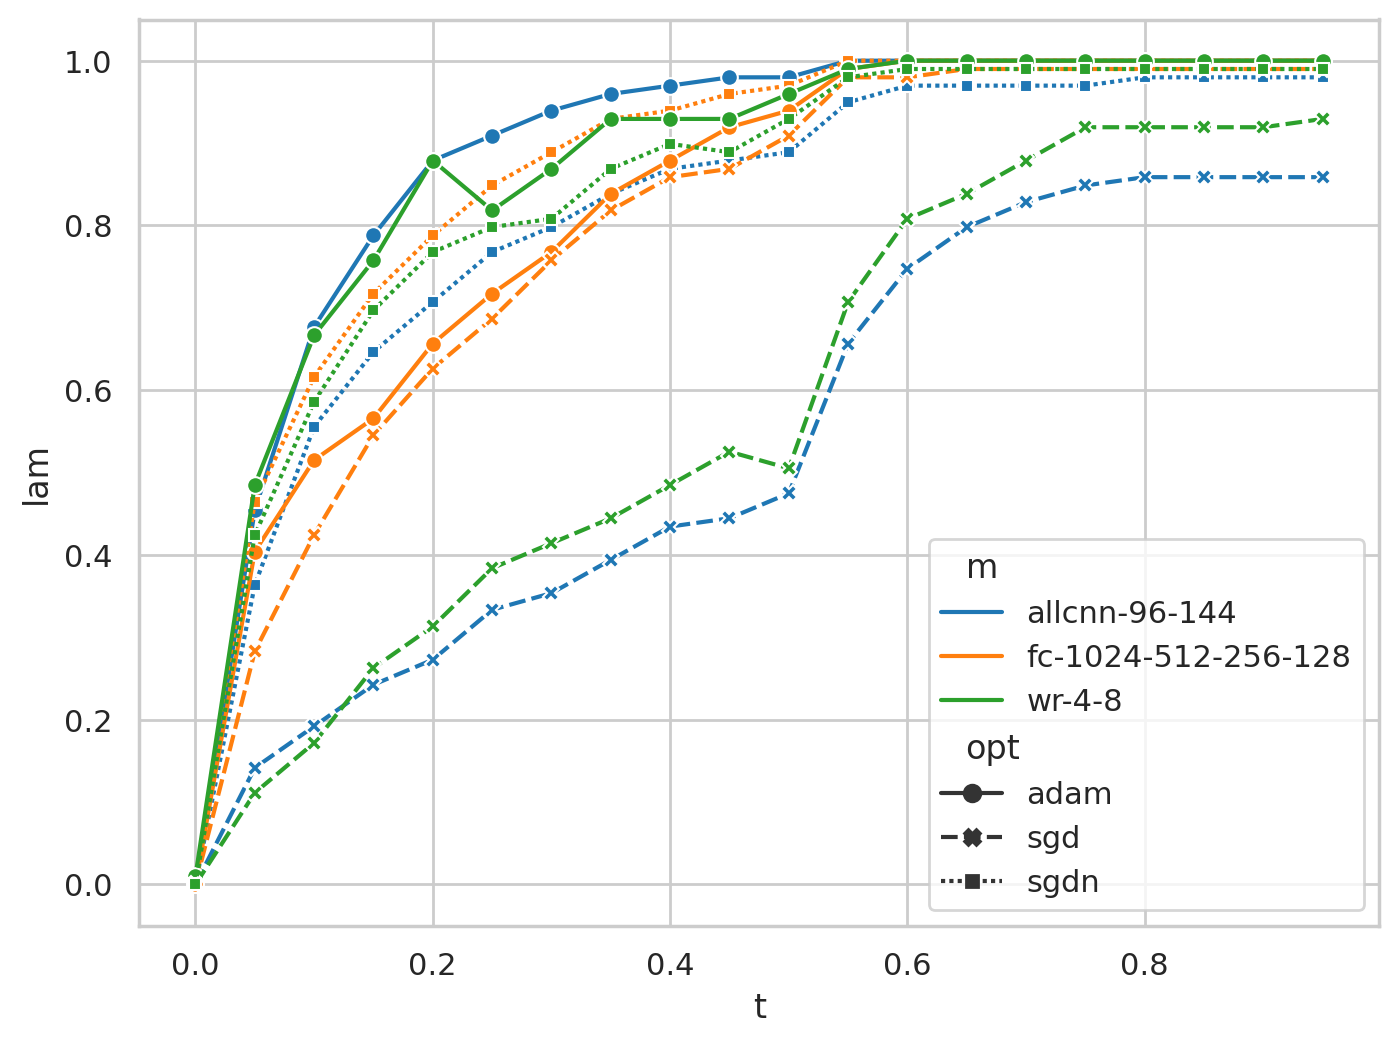

In [15]:
d_ = d.iloc[get_idx(d,"seed==42")]
sns.lineplot(data=d_, x='t', y='lam', hue='m', style='opt', markers=True)

In [12]:
lams = projection((yhs).reshape(-1, 10), ps.reshape(-1, 10), qs.reshape(-1, 10), True, mode='mean')
lams = lams.reshape(1800, -1)
d['lams'] = lams.mean(1)
d['std'] = np.std(lams, axis=1)
d_ = d.iloc[get_idx(d,"seed==42")]

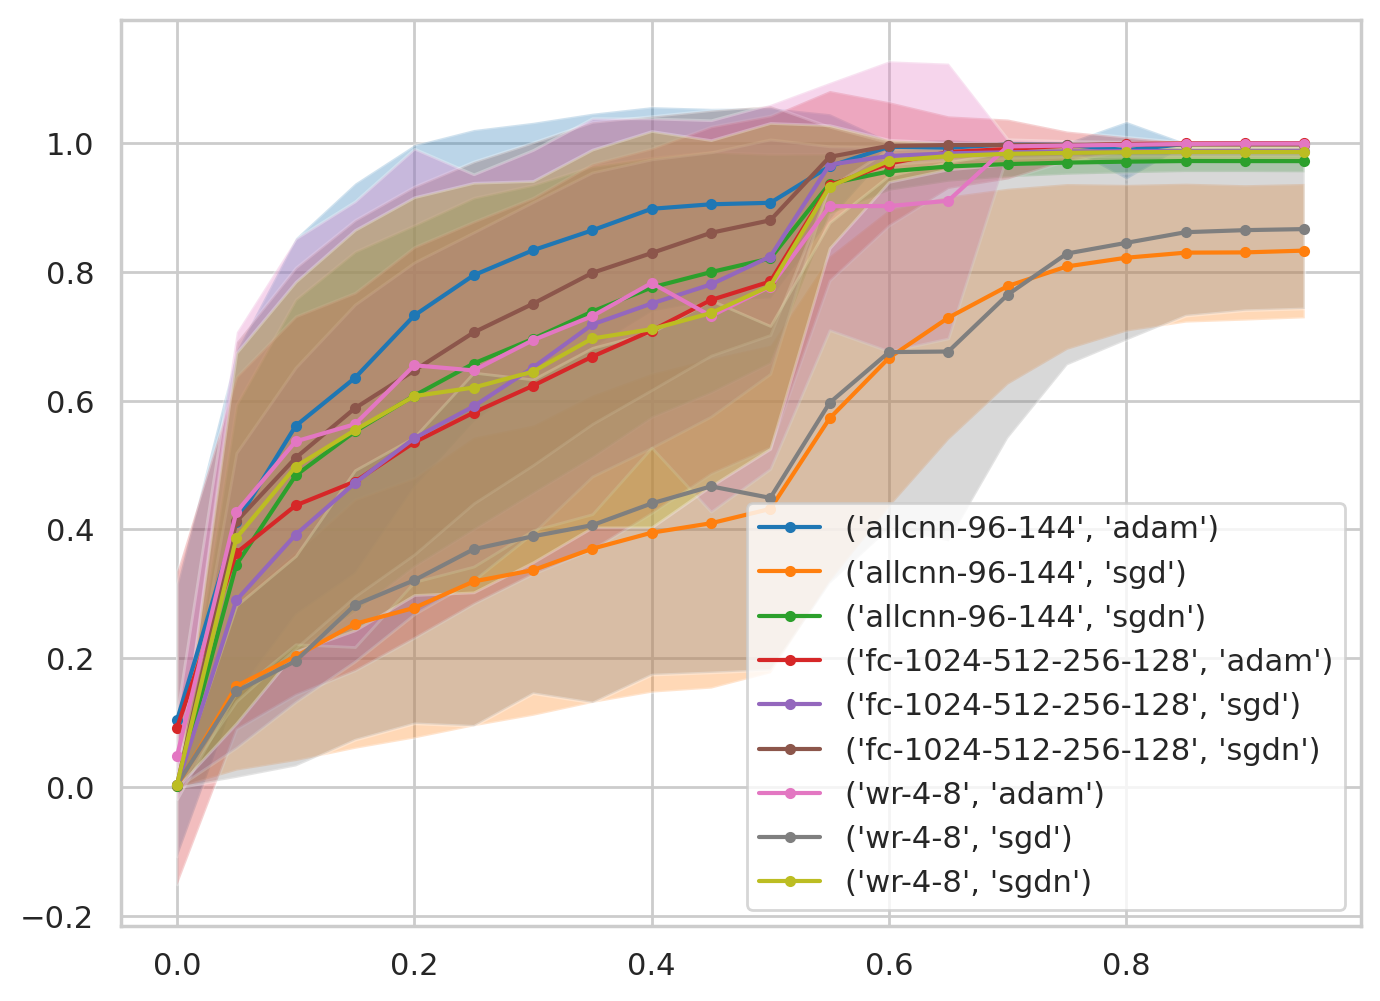

In [13]:
idxs = d_.groupby(['m', 'opt']).indices
for config in idxs.keys():
    idx = idxs[config]
    di = d_.iloc[idx]
    plt.plot(di['t'], di['lams'], '.-', label=str(config))
    plt.fill_between(di['t'], di['lams'] - di['std'], di['lams'] + di['std'], alpha=0.3)
plt.legend()

### Project from uniform-->target to trajectory

In [3]:
loc = 'results/models/new'

In [70]:
d = th.load(os.path.join(loc, 'all_with_lam.p'))

In [10]:
def projection(r, p, q, debug=False, mode='prod'):
    # r, p, q shape (nmodels, nsamples, nclasses)
    nm, ns, nc = r.shape
    if debug:
        assert np.allclose([(r**2).sum(-1), (p**2).sum(-1), (q**2).sum(-1)], 1)
    cost, cost1, cost2 = (p*q).sum(-1, keepdims=True), (p*r).sum(-1, keepdims=True), (q*r).sum(-1, keepdims=True)
    if mode == 'prod':
        if cost.max() > 1 or cost.min()<0:
            cost[cost> 1] = 1
            cost[cost< 0] = 0
        ti = np.arccos(cost)
        d1 = np.arccos(cost1[ti == 0]).sum()
        cost1, cost2 = cost1[ti > 0], cost2[ti > 0]
        ti = ti[ti > 0]

        def d(t): 
            coss = cost1*np.sin((1-t)*ti) / np.sin(ti) + cost2 * np.sin(t*ti)/np.sin(ti)
            if coss.max() > 1 or coss.min() < 0:
                coss[coss > 1] = 1
                coss[coss < 0] = 0
            return d1 + np.arccos(coss).sum()
        d0 = d(0)
        lams = np.linspace(0, 1, 100)
        lam = np.zeros([nm, 1])
        for (i, dt) in enumerate(map(d, lams)):
            lam[dt < d0] = lams[i]
            d0 = dt
    elif mode == 'mean':
        tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
        lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
        lam[lam > 1] = 1
    return lam


In [11]:
def gamma(t, p, q):
    # p, q shape: nmodels, nsamples, nclasses
    cospq = (p*q).sum(-1)
    if cospq.max() > 1 or cospq.min() < 0: 
        cospq[cospq > 1] = 1
        cospq[cospq < 0] = 0
    ti = np.arccos(cospq)
    mask = ti==0
    gamma = np.zeros_like(p)
    gamma[mask, :] = p[mask, :]
    p, q = p[~mask, :], q[~mask, :]
    ti = ti[~mask, None]
    gamma[~mask, :] = np.sin((1-t)*ti) / np.sin(ti) * \
        p + np.sin(t*ti) / np.sin(ti) * q
    return gamma


In [7]:
ps = np.sqrt(np.ones([1, 50000, 10]) / 10)
ds = get_data()['train']
y_ = np.array(ds.targets, dtype=np.int32)
y = np.zeros((y_.size, y_.max()+1))
y[np.arange(y_.size), y_] = 1
qs = np.expand_dims(y, axis=0) 

In [13]:
new_avg = []
groups = ['m', 'opt', 'seed']
configs = d.groupby(groups).indices
ts = np.linspace(0, 1, 51)[1:]
for (c, idx) in configs.items():
    di = d.iloc[idx]
    for t in ts:
        data = {groups[i]:c[i] for i in range(len(c))}
        data['t'] = t
        k1 = di[di['lam'] >= t]['t']
        k2 = di[di['lam'] < t]['t']
        ks = set(k2.index).intersection(set(k1.index-1)).intersection(set(di.index[:-1]))
        if len(ks) == 0:
            # continue
            ks = set(di.index[-1:]-1)
        diff = 1
        for k in ks:
            p = np.sqrt(di.loc[k]['yh'])[None, :]
            q = np.sqrt(di.loc[k+1]['yh'])[None, :]
            r = gamma(t, ps, qs)
            lam = projection(r, p, q)
            if abs(lam-0.5) < diff:
                diff = abs(lam-0.5)
                data['yh'] = (gamma(lam, p, q) ** 2).squeeze()
                data['err'] = (np.argmax(data['yh'], axis=-1) != y_).mean()
                data['favg'] = -np.log(data['yh'])[:, np.arange(len(y_)), y_].mean()
        # data['yh'] = gamma(lam, p, q)
        print(c, t, k, lam, data['err'], data['favg'])
        new_avg.append(data)


('allcnn-96-144', 'adam', 42) 0.02 0 [[0.54545455]] 0.43712 1.4614946
('allcnn-96-144', 'adam', 42) 0.04 0 [[0.55555556]] 0.42792 1.4454085
('allcnn-96-144', 'adam', 42) 0.06 0 [[0.56565657]] 0.42084 1.4297484
('allcnn-96-144', 'adam', 42) 0.08 0 [[0.57575758]] 0.41398 1.4145064
('allcnn-96-144', 'adam', 42) 0.1 0 [[0.58585859]] 0.40788 1.3996737
('allcnn-96-144', 'adam', 42) 0.12 0 [[0.5959596]] 0.40218 1.3852432
('allcnn-96-144', 'adam', 42) 0.14 0 [[0.60606061]] 0.39706 1.3712074
('allcnn-96-144', 'adam', 42) 0.16 0 [[0.61616162]] 0.3925 1.3575597
('allcnn-96-144', 'adam', 42) 0.18 0 [[0.62626263]] 0.38818 1.3442935
('allcnn-96-144', 'adam', 42) 0.2 0 [[0.63636364]] 0.3846 1.3314023
('allcnn-96-144', 'adam', 42) 0.22 0 [[0.64646465]] 0.38104 1.3188807
('allcnn-96-144', 'adam', 42) 0.24 0 [[0.65656566]] 0.37868 1.3067228
('allcnn-96-144', 'adam', 42) 0.26 0 [[0.66666667]] 0.37652 1.2949231
('allcnn-96-144', 'adam', 42) 0.28 0 [[0.67676768]] 0.3748 1.2834768
('allcnn-96-144', 'adam', 

/tmp/ipykernel_8216/816156985.py:26: RuntimeWarning: divide by zero encountered in log
  data['favg'] = -np.log(data['yh'])[:, np.arange(len(y_)), y_].mean()


('fc-1024-512-256-128', 'adam', 42) 1.0 71 [[1.]] 0.02032 0.05660035
('fc-1024-512-256-128', 'adam', 43) 0.02 240 [[0.29292929]] 0.71912 1.9617498
('fc-1024-512-256-128', 'adam', 43) 0.04 240 [[0.3030303]] 0.70962 1.9423057
('fc-1024-512-256-128', 'adam', 43) 0.06 240 [[0.32323232]] 0.69076 1.9048399
('fc-1024-512-256-128', 'adam', 43) 0.08 240 [[0.33333333]] 0.68092 1.88679
('fc-1024-512-256-128', 'adam', 43) 0.1 240 [[0.35353535]] 0.66176 1.851992
('fc-1024-512-256-128', 'adam', 43) 0.12 240 [[0.36363636]] 0.65296 1.8352205
('fc-1024-512-256-128', 'adam', 43) 0.14 240 [[0.38383838]] 0.63494 1.8028791
('fc-1024-512-256-128', 'adam', 43) 0.16 240 [[0.39393939]] 0.62734 1.787289
('fc-1024-512-256-128', 'adam', 43) 0.18 240 [[0.41414141]] 0.61056 1.7572267
('fc-1024-512-256-128', 'adam', 43) 0.2 240 [[0.42424242]] 0.60266 1.7427372
('fc-1024-512-256-128', 'adam', 43) 0.22 240 [[0.44444444]] 0.5883 1.714804
('fc-1024-512-256-128', 'adam', 43) 0.24 240 [[0.45454545]] 0.58086 1.7013459
('fc

In [27]:
df = pd.DataFrame(new_avg)

In [29]:
df['yh'] = df.apply(lambda r: r.yh.squeeze(), axis=1)

In [16]:
th.save(df, os.path.join(loc, 'new_avg.p'))

In [5]:
df = th.load(os.path.join(loc,  'new_avg.p'))

In [ ]:
avg = avg_model(df, groupby=['m', 'opt', 't'], probs=True, get_err=True, update_d=True, compute_distance=False, dev='cuda', keys=['yh'])['d']
dists, configs = pairwise_dist_batch(avg, groups=['m', 'opt', 'seed'], s=0.0, batch=2, sym='mean', normalization='length')

In [33]:
symd = dists
symd[np.tril_indices(len(dists), -1)] = 0
symd = symd + symd.T

In [34]:
th.save({'dists': dists, 'symd': symd, 'configs': configs, 'groups': ['m', 'opt'] + ['seed']},
        os.path.join(loc, f'new_avg_0.0_mean_length.p'))


<AxesSubplot:xlabel='t', ylabel='err'>

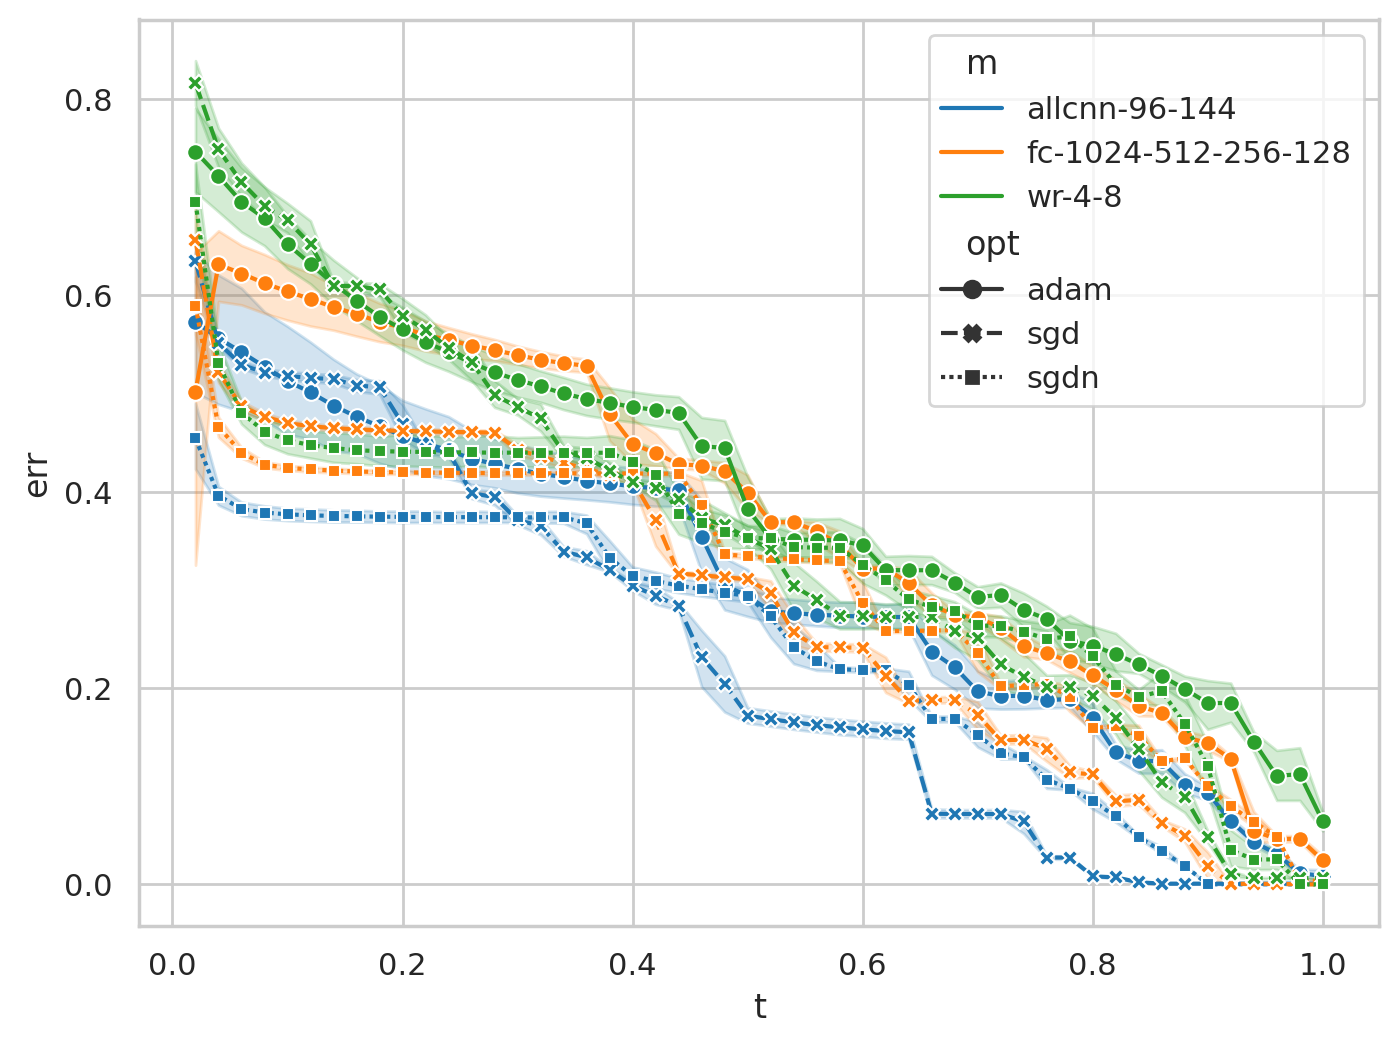

In [39]:
sns.lineplot(data=df, x='t', y='err', hue='m', style='opt', markers=True)

In [67]:
avg = avg_model(df, groupby=['m', 'opt', 't'], probs=True, get_err=True, update_d=True, compute_distance=True, dev='cuda', keys=['yh'], distf=dbhat)

<AxesSubplot:xlabel='t', ylabel='dist'>

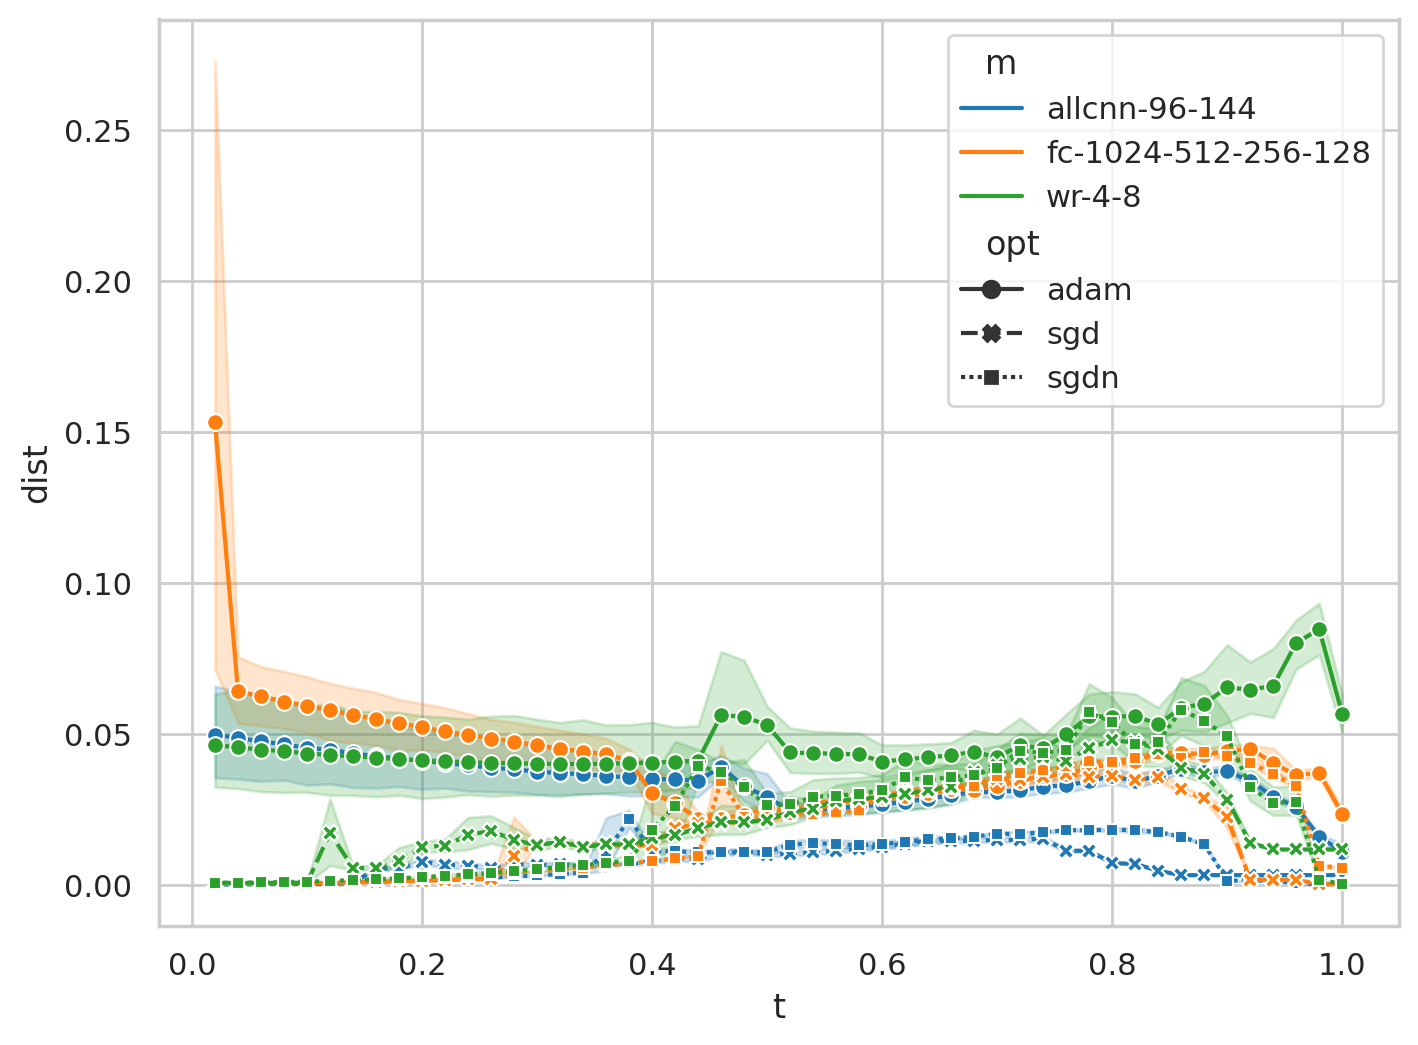

In [68]:
sns.lineplot(data=avg['dists'], x='t', y='dist', hue='m', style='opt', markers=True)

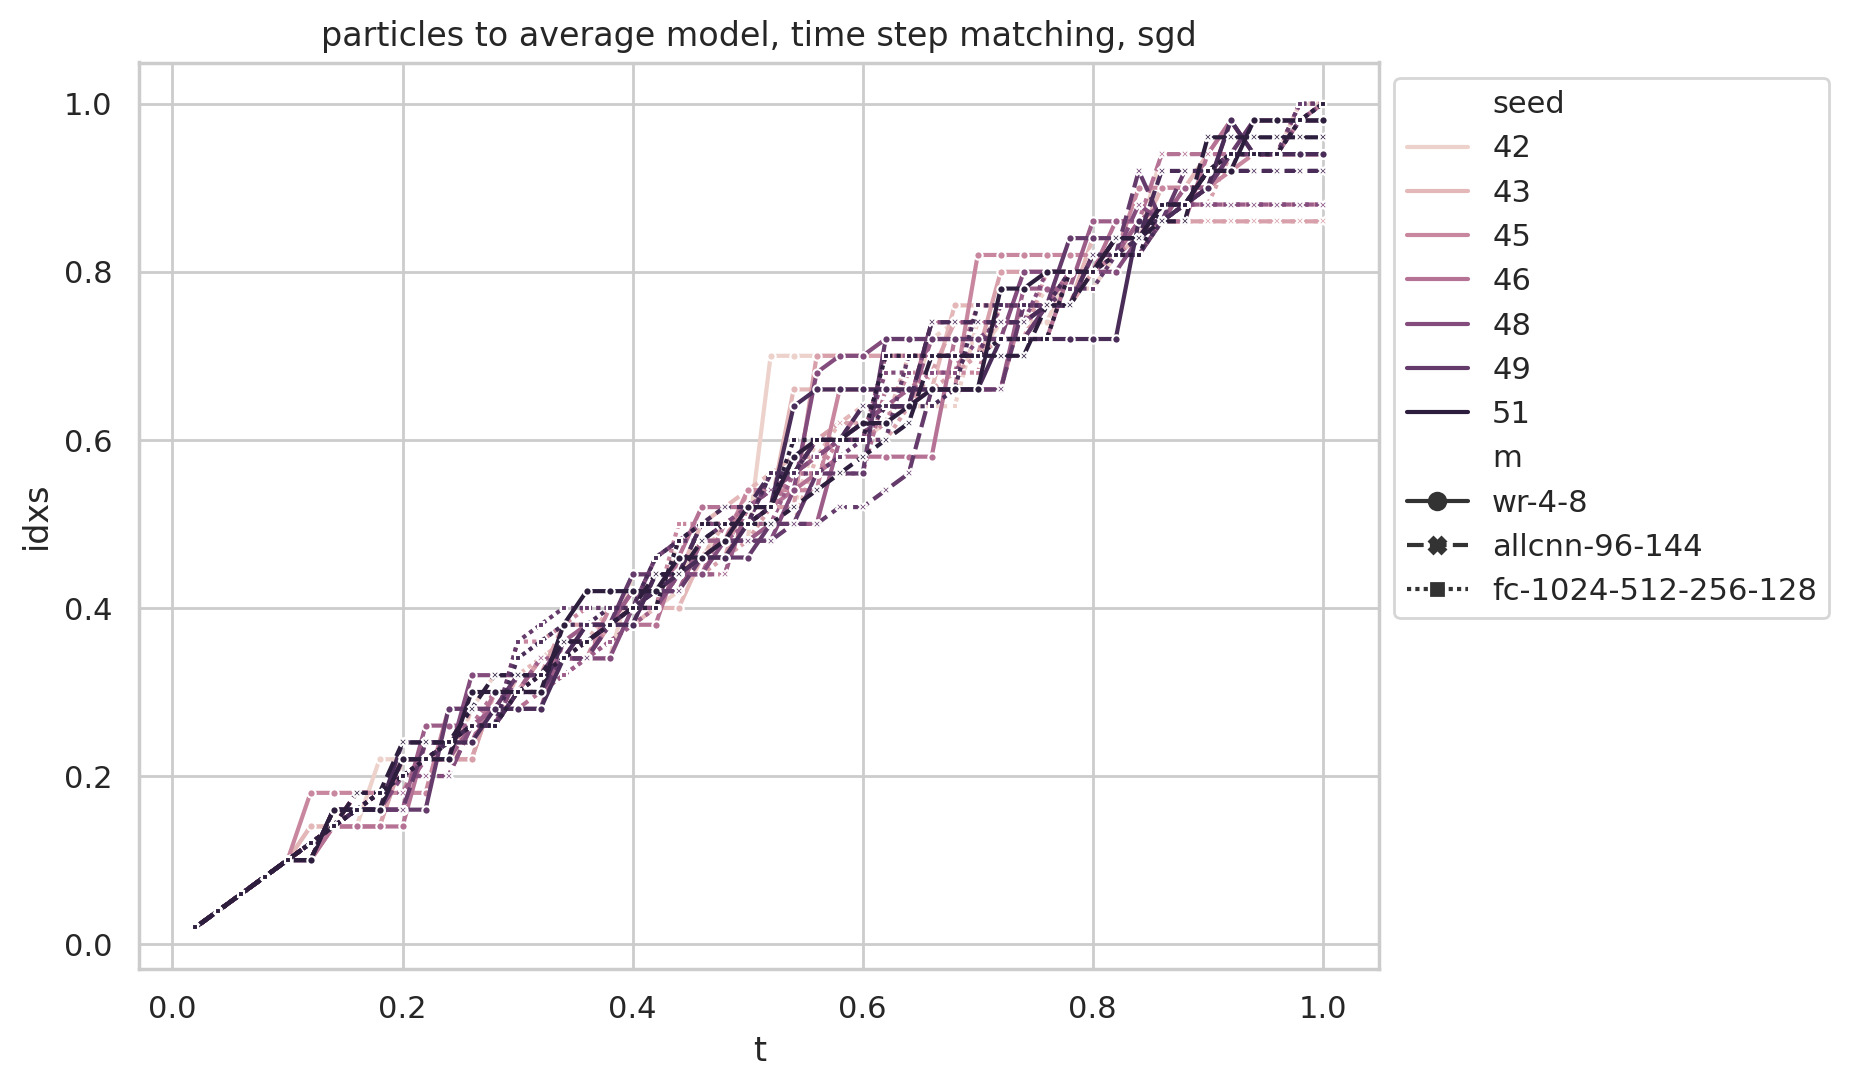

In [55]:
i = 2
ax = sns.lineplot(data=dists[dists['opt'] == opts[i]], x='t', y='idxs', hue='seed',
                  style='m', markers=True, markersize=3)
ax.set_title(f'particles to average model, time step matching, {opts[i]}')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

<AxesSubplot:xlabel='t', ylabel='dist'>

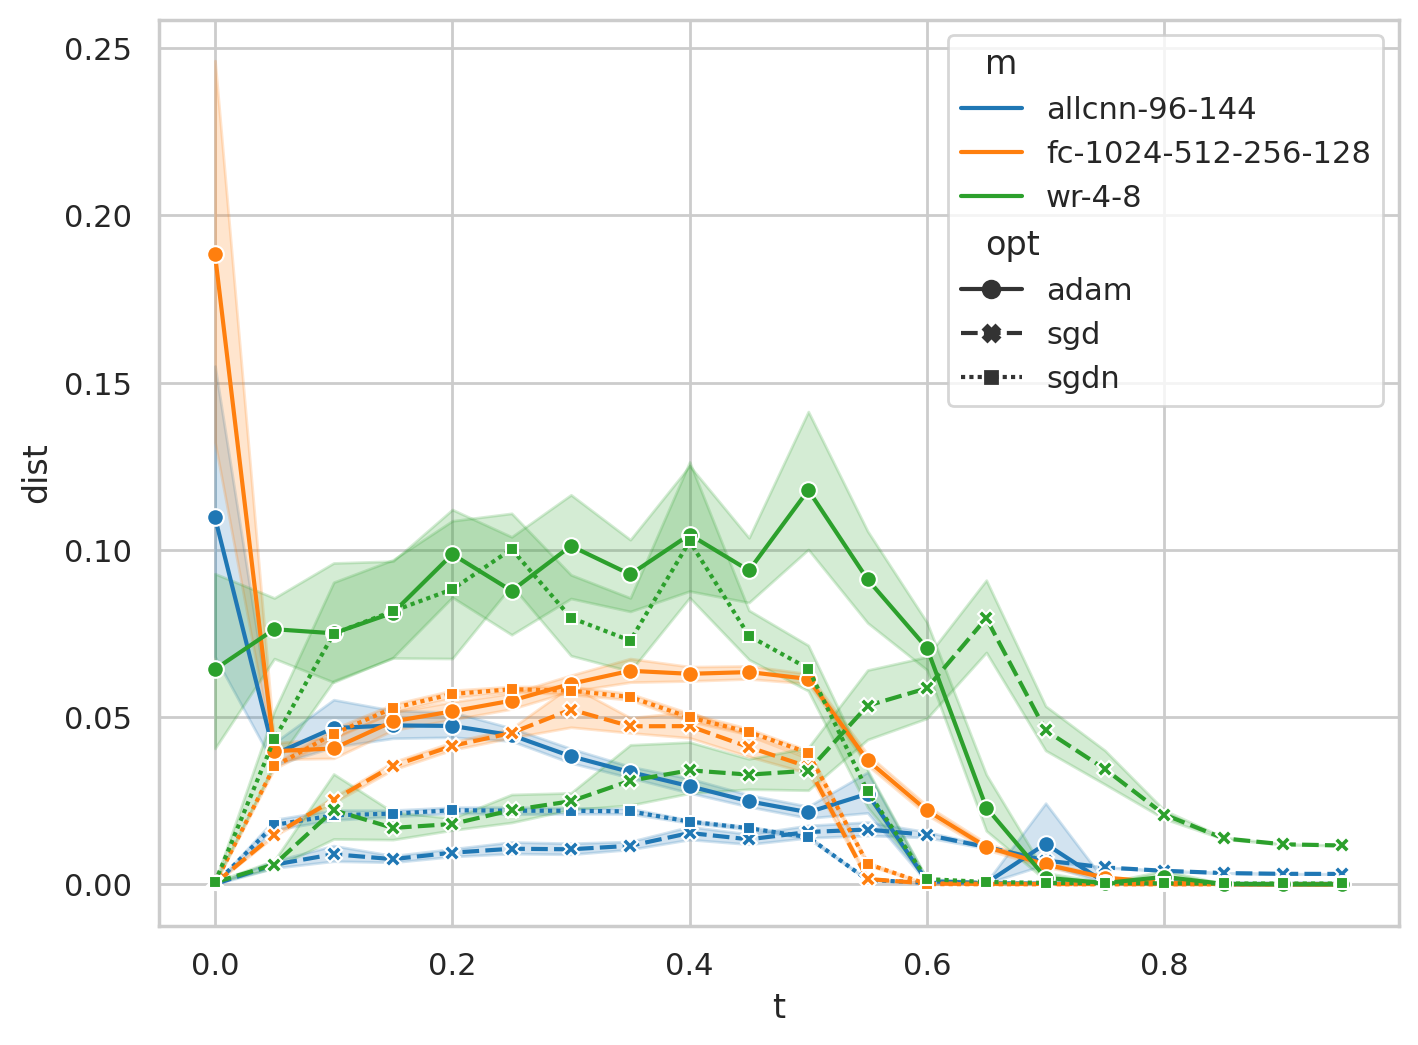

In [73]:
avg_ = avg_model(d, groupby=['m', 'opt', 't'], probs=True, get_err=True,
                update_d=True, compute_distance=True, dev='cuda', keys=['yh'], distf=dbhat)
sns.lineplot(data=avg_['dists'], x='t', y='dist',
             hue='m', style='opt', markers=True)
